# Goal

To group customers into meaningful groups using 
1. Kmean clustering
    * 1a.  All event data 
    * 1b. RFI clustering 
2. RFM analysis
    * Analysis of RFI clustering, RFM manual buckets using quantiles and business knowledge
3. Cohort analysis

## Setup config and Data Import

In [1]:
# PYTHON MODULES

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import functools
from pyspark.sql import functions as f
from pandas.plotting import parallel_coordinates

In [2]:
import findspark
findspark.init()

import pyspark;
#get_ipython().profile_dir.startup_dir

In [3]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages net.snowflake:snowflake-jdbc:3.6.24,net.snowflake:spark-snowflake_2.11:2.4.12-spark_2.3 pyspark-shell'

In [4]:
# PYSPARK MODULES

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *
from pyspark import SparkConf, SparkContext 

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator

In [5]:
spark = SparkSession.builder.master('local').appName('test').config('spark.driver.memory', '5G').getOrCreate()

Py4JError: An error occurred while calling None.org.apache.spark.api.python.PythonAccumulatorV2. Trace:
py4j.Py4JException: Constructor org.apache.spark.api.python.PythonAccumulatorV2([class java.lang.String, class java.lang.Integer, class java.lang.String]) does not exist
	at py4j.reflection.ReflectionEngine.getConstructor(ReflectionEngine.java:179)
	at py4j.reflection.ReflectionEngine.getConstructor(ReflectionEngine.java:196)
	at py4j.Gateway.invoke(Gateway.java:237)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)



In [6]:
spark.builder.config('spark.executor.memory', '16G')
spark.builder.config("spark.executor.cores", "4")

In [7]:
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"
sfOptions = {"sfURL":"cengage.snowflakecomputing.com",\
             "sfAccount":"cengage", "sfUser":"shweta.purushe@cengage.com",\
             "sfPassword":"Sanatsadhale2017", "sfDatabase":"dev", "sfSchema":"zsp", "sfWarehouse":"ANALYSIS"}

In [ ]:
# ALL Event data from the CU Dashboard
#df = spark.read.format(SNOWFLAKE_SOURCE_NAME).options(**sfOptions).option("query", "select * from dev.zsp.sub_count14_dataleak").load()

In [8]:
rfi_df = spark.read.format(SNOWFLAKE_SOURCE_NAME).options(**sfOptions).option("query", "select * from dev.zsp.rfi where intensity is not null").load()

## 1. Segmentation using KMeans clustering

Assumptions of Kmeans clustering
1. The data should be symmetrical -- check for skewness
2. Same variance of each variable 
3. Same mean of each variable so that all variables contribute equally to the clustering. 

Therefore the pipeline should be 
1. Check for Skewness -- fix with log transformation
2. Check for centrality -- fix with z score normalization (subtract by mean and divide by std)
3. Kmeans

### 1a) KMeans clustering of ALL Event data from the CU Dashboard
Purpose is to identify behavioral groups

### 1b) KMeans clustering of Recency Frequency Intensity data 
Purpose is to identify a more distilled subset of behavioral groups

1. Preprocessing
2. Find best k
3. KMeans using k  -- provides cluster labels per User ID
4. Cluster analysis -- analyze aaverage RFI values for every cluster 

In [9]:
rfi_df.show(2)

+--------------------+-------------------+---------------------+---------+---------+-------+----------+----------+----------+-----------+---------+
|       USER_SSO_GUID|SUBSCRIPTION_STATUS|RETURNING_CU_CUSTOMER|FREQUENCY|INTENSITY|RECENCY|R_QUARTILE|F_QUARTILE|I_QUARTILE|RFI_SEGMENT|RFI_SCORE|
+--------------------+-------------------+---------------------+---------+---------+-------+----------+----------+----------+-----------+---------+
|4dc089892bf291ef:...|      Trial Expired| Tried Before, No ...|      139|      2.4|     15|         2|         2|         4|        224|        8|
|293269ae1817be40:...|               null|                  New|       19|      2.4|    165|         4|         3|         4|        434|       11|
+--------------------+-------------------+---------------------+---------+---------+-------+----------+----------+----------+-----------+---------+
only showing top 2 rows



1. Preprocessing
    1. Log transformation to fix skewness if any 
    2. Standard Scaling to bring means and variances of columns closer 

In [10]:
# Getting the numerical columns 
rfi_columns = ['FREQUENCY','INTENSITY','RECENCY']
rfi_exprs = {x: "skewness" for x in rfi_columns}
rfi_exprs

{'FREQUENCY': 'skewness', 'INTENSITY': 'skewness', 'RECENCY': 'skewness'}

**Checking for skewness**

In [11]:
rfi_skew = rfi_df[rfi_columns].groupby().agg(rfi_exprs).collect()[0].asDict()

rfi_skewness = pd.DataFrame.from_dict(rfi_skew, orient="index")
rfi_skewness.columns = ['Skewness']
rfi_skewness = rfi_skewness[rfi_skewness.notnull()]

**A. Fixing skewness using LOG TRANSFORMATION**

In [14]:
# rfi_log1p = rfi_df.select([ f.log10 
#                                     (
#                                         f.col(colm) + 1 #some values might be 0 counts
#                                     ).name(colm)    
#                                 for colm in rfi_columns ])


rfi_log1p = functools.reduce(
    #1. function 
    lambda df, column_name: df.withColumn(column_name, #+"_L",  not changing the name, they are the log transformed values of the original RFI columns
                                   f.log10 (
                                        f.col(column_name) + 1 #log+ 1 
                                    ))
    
    #2. Subset of columns to be log transformed
    ,rfi_columns
    #3. Source data 
    , rfi_df
)
rfi_log1p.select(['USER_SSO_GUID'] + rfi_columns).show(5)

+--------------------+------------------+------------------+------------------+
|       USER_SSO_GUID|         FREQUENCY|         INTENSITY|           RECENCY|
+--------------------+------------------+------------------+------------------+
|cdc5e869bfd5299b:...|1.2304489213782739|0.6989700043360189|1.8129133566428555|
|dff9bcab11be7417:...| 2.093421685162235|0.6989700043360189| 1.146128035678238|
|9f8190316b7426f2:...|1.2304489213782739|0.6989700043360189| 2.110589710299249|
|42d53316f06b483b:...|1.2304489213782739|0.6989700043360189|2.2174839442139063|
|231938d8c1393659:...|1.1139433523068367|0.6989700043360189| 2.214843848047698|
+--------------------+------------------+------------------+------------------+
only showing top 5 rows



In [15]:
rfi_log1p_skew = rfi_log1p[rfi_columns].groupby().agg(rfi_exprs).collect()[0].asDict()

rfi_log1p_skewness = pd.DataFrame.from_dict(rfi_log1p_skew, orient="index")
rfi_log1p_skewness.columns = ['Skewness_after_log']
rfi_log1p_skewness = rfi_log1p_skewness[rfi_log1p_skewness.notnull()]

Text(0.5, 1.0, 'Log plus 1 transformation demonstrably reduces skew')

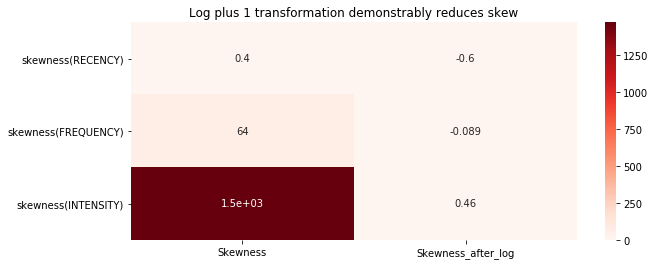

In [16]:
#Visualizing log1p transformed reducing skew

plt.figure(figsize=(10,4))
ax2 = sns.heatmap(rfi_skewness.join(rfi_log1p_skewness).sort_values(by='Skewness'), annot=True, cmap='Reds')
plt.title('Log plus 1 transformation demonstrably reduces skew')

**B. Scaling the data using a Standard Scaler**

In [17]:
# The columns need to be assembled into a single feature column before standard scaling them 
rfi_assembler = VectorAssembler( inputCols = rfi_columns, outputCol = 'unscaled_features' )

rfi_scaler = StandardScaler( inputCol = 'unscaled_features', outputCol = 'features', withMean = True, withStd = True )

rfi_sca_pip = Pipeline(stages= [rfi_assembler, rfi_scaler])

In [18]:
rfi_scaled_df = rfi_sca_pip.fit(rfi_log1p).transform(rfi_log1p)

**2. Finding the best K**

In [19]:
s_of_s = {}
max_k = 20
for k in range(2, max_k + 1, 2):
    km = KMeans(k= k, seed=1, featuresCol='features', predictionCol='prediction')
    k_model = km.fit(rfi_scaled_df)
    
    s_of_s[k] = k_model.computeCost(rfi_scaled_df)
    print('Completed Kmeans with {} clusters'.format(k))

Completed Kmeans with 2 clusters
Completed Kmeans with 4 clusters
Completed Kmeans with 6 clusters
Completed Kmeans with 8 clusters
Completed Kmeans with 10 clusters
Completed Kmeans with 12 clusters
Completed Kmeans with 14 clusters
Completed Kmeans with 16 clusters
Completed Kmeans with 18 clusters
Completed Kmeans with 20 clusters


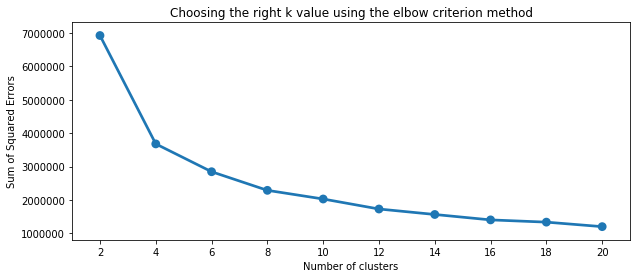

In [20]:
plt.figure(figsize=(10,4))

ax = sns.pointplot(x=list(s_of_s.keys()), y=list(s_of_s.values()))
plt.title('Choosing the right k value using the elbow criterion method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors');

Looks like 4 clusters seems to be a good value for k. But we should experiment with 4 - 10 'k' values.

**3. KMeans with different cluster numbers**

Building customer personas using summary statistics of the RFI values per cluster.

In [21]:
# This function calculates the avg rfi metrics for a cluster and returns a processed pandas df which can be used 
# for visualization

def avg_rfi_per_cluster(sp_df):
    pandas_df = sp_df.select(rfi_columns + ['prediction'])\
            .groupby('prediction')\
            .agg({
                'FREQUENCY':'avg',
                'INTENSITY':'avg',
                'RECENCY':'avg',
                '*': 'count'
            }).toPandas()
    
    pandas_df.prediction = pandas_df.prediction.astype('category')
    pandas_df = pandas_df.drop(['count(1)'], axis = 1)
    return pandas_df

In [29]:
#kmeans_4 = KMeans(k = 4, seed = 1, featuresCol='features', predictionCol='prediction')
#clus_df4 = kmeans_4.fit(rfi_scaled_df).transform(rfi_scaled_df)

kmeans_5 = KMeans(k =5, seed = 1, featuresCol='features', predictionCol='prediction')
clus_df5 = kmeans_5.fit(rfi_scaled_df).transform(rfi_scaled_df)

kmeans_6 = KMeans(k = 6, seed = 1, featuresCol = 'features', predictionCol = 'prediction')
clus_df6 = kmeans_6.fit(rfi_scaled_df).transform(rfi_scaled_df)


# k = 8 clusters
kmeans_8 = KMeans(k = 8, seed = 1, featuresCol = 'features', predictionCol = 'prediction')
clus_df8 = kmeans_8.fit(rfi_scaled_df).transform(rfi_scaled_df)

kmeans_9 = KMeans(k = 9, seed = 1, featuresCol = 'features', predictionCol = 'prediction')
clus_df9 = kmeans_9.fit(rfi_scaled_df).transform(rfi_scaled_df)

# k = 10 clusters

kmeans_10 = KMeans(k = 10, seed = 1, featuresCol = 'features', predictionCol = 'prediction')
clus_df10 = kmeans_10.fit(rfi_scaled_df).transform(rfi_scaled_df)

In [30]:
k4_result = avg_rfi_per_cluster(clus_df4)
k5_result = avg_rfi_per_cluster(clus_df5)
k6_result = avg_rfi_per_cluster(clus_df6)
k8_result = avg_rfi_per_cluster(clus_df8)
k9_result = avg_rfi_per_cluster(clus_df9)
k10_result = avg_rfi_per_cluster(clus_df10)

### RFI KMeans clustering analysis

##### Visualizations

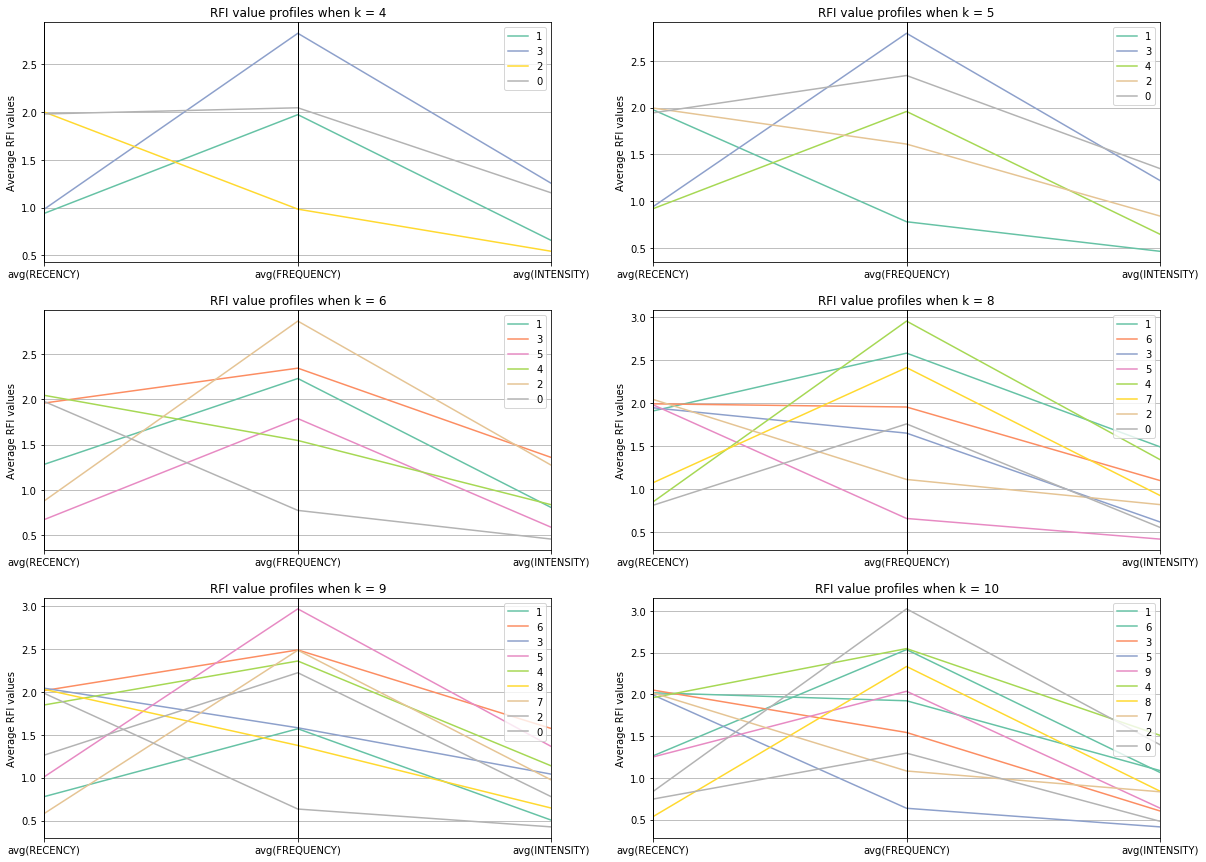

In [31]:
plt.figure(figsize =(20, 15))

plt.subplot(3, 2, 1); parallel_coordinates(k4_result, 'prediction',colormap=plt.get_cmap("Set2"))
plt.title('RFI value profiles when k = 4')
plt.ylabel('Average RFI values')


plt.subplot(3, 2, 2);parallel_coordinates(k5_result, 'prediction',colormap=plt.get_cmap("Set2"))
plt.title('RFI value profiles when k = 5')
plt.ylabel('Average RFI values')

plt.subplot(3, 2, 3);parallel_coordinates(k6_result, 'prediction',colormap=plt.get_cmap("Set2"))
plt.title('RFI value profiles when k = 6')
plt.ylabel('Average RFI values')

plt.subplot(3, 2, 4);parallel_coordinates(k8_result, 'prediction',colormap=plt.get_cmap("Set2"))
plt.title('RFI value profiles when k = 8')
plt.ylabel('Average RFI values')

plt.subplot(3, 2, 5);parallel_coordinates(k9_result, 'prediction',colormap=plt.get_cmap("Set2"))
plt.title('RFI value profiles when k = 9')
plt.ylabel('Average RFI values')

plt.subplot(3, 2, 6);parallel_coordinates(k10_result, 'prediction',colormap=plt.get_cmap("Set2"))
plt.title('RFI value profiles when k = 10')
plt.ylabel('Average RFI values')

plt.show()

Relative importance of RFI attributes per cluster

In [32]:
#Population average
pop_avg = rfi_df.groupby().mean('RECENCY', 'FREQUENCY', 'INTENSITY').collect()[0]
pop_avg = pd.Series(pop_avg, dtype='float')
pop_avg.index = ['avg(RECENCY)', 'avg(FREQUENCY)', 'avg(INTENSITY)']

In [33]:
def rel_imp_calculator(df, pop_df):
    cluster_avg = df.loc[:, ['avg(RECENCY)', 'avg(FREQUENCY)', 'avg(INTENSITY)']]
    return (cluster_avg / pop_df - 1)

In [34]:
#relative importance
relative_imp_4 = rel_imp_calculator(k4_result, pop_avg)
relative_imp_5 = rel_imp_calculator(k5_result, pop_avg)
relative_imp_6 = rel_imp_calculator(k6_result, pop_avg)
relative_imp_8 = rel_imp_calculator(k8_result, pop_avg)
relative_imp_9 = rel_imp_calculator(k9_result, pop_avg)
relative_imp_10 = rel_imp_calculator(k10_result, pop_avg)

**Visualizing Relative Importance of each attribute in a segment /cluster.**

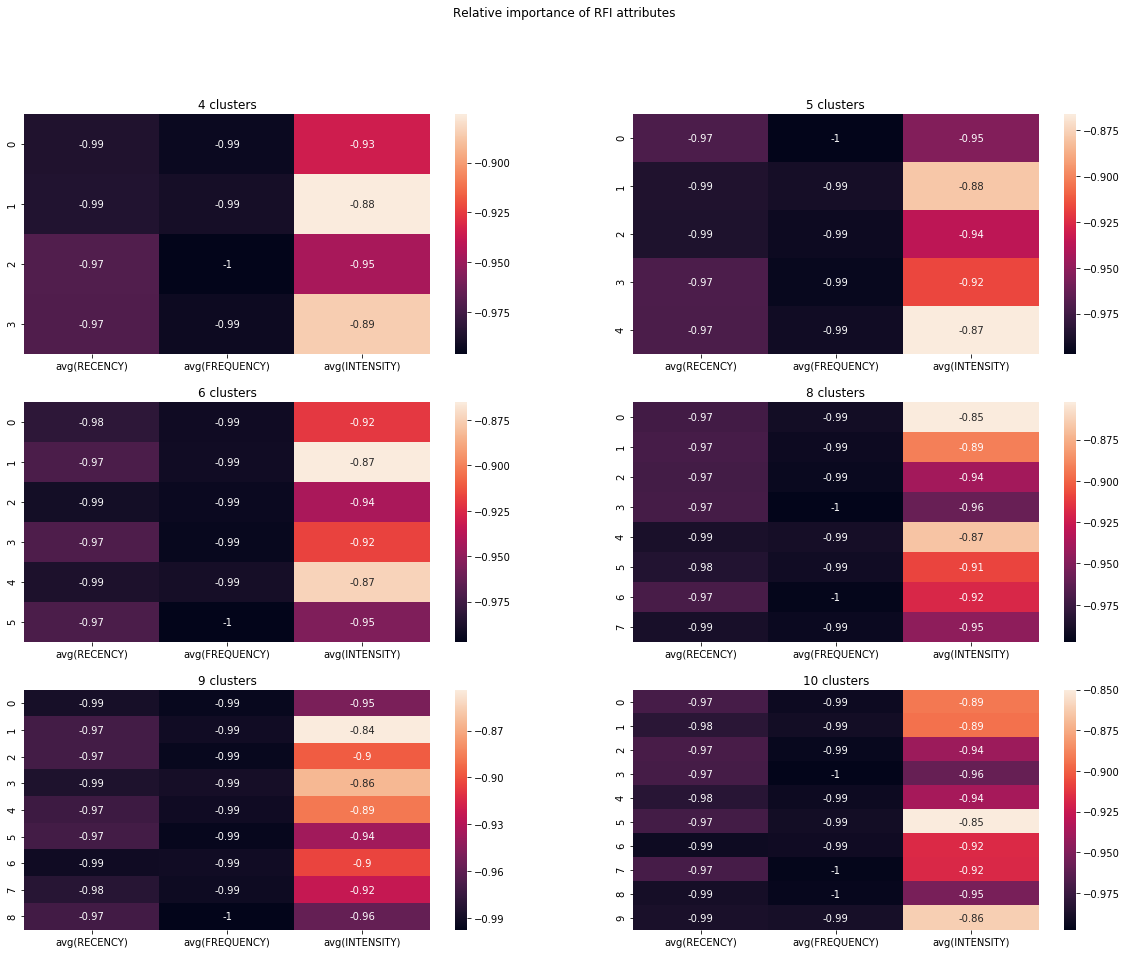

In [35]:
plt.figure(figsize=(20, 15))
plt.suptitle('Relative importance of RFI attributes')

plt.subplot(3,2,1); sns.heatmap(relative_imp_4,annot=True)
plt.title('4 clusters')

plt.subplot(3,2,2); sns.heatmap(relative_imp_5,annot=True)
plt.title('5 clusters')

plt.subplot(3,2,3); sns.heatmap(relative_imp_6,annot=True)
plt.title('6 clusters')

plt.subplot(3,2,4); sns.heatmap(relative_imp_8,annot=True)
plt.title('8 clusters')

plt.subplot(3,2,5); sns.heatmap(relative_imp_9,annot=True)
plt.title('9 clusters')

plt.subplot(3,2,6); sns.heatmap(relative_imp_10,annot=True)
plt.title('10 clusters')
plt.show()

## 2. Segmentation using RFI analysis 
Use manual thresholds to create buckets and pool with results from 1b above.

1. Segment using quantiles -- completed in Snowflake already
2. Manual buckets 
3. Bucket analysis
4. Combine with results of 1b above

## 3. Segmentation using Cohorts

In [36]:
spark.stop()